In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torchinfo as torchinfo

from PIL import Image
from PIL import ImageOps
from src.training import fit
from collections import Counter
from src.evaluation import evaluate_model
from torchvision import datasets, transforms
from src.training import plot_train_results_from_json
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler

# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# Path de descarga de datasets usando KaggleHub
os.environ["KAGGLEHUB_CACHE"] = "./"

# PARAMETROS GLOBALES
BATCH_SIZE = 64
WORKERS = 4
DATASET_AUGMENTED_SIZE = 4000

print(f'Dispositivo a utilizar: {device}')

Dispositivo a utilizar: cuda


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Para multi-GPU (si aplica)

    # Determinismo en cuDNN (puede impactar en performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [3]:
def print_model_params(model):
    """Imprime el número de parámetros del modelo.
    """
    print(
        f"Modelo: {model.__class__.__name__} aplicando "
        f"{'Transfer Learning' if 'tl' in model.__class__.__name__ else 'Fine Tuning'}"
    )
    print(f"Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Parámetros totales: {sum(p.numel() for p in model.parameters())}")
    print()

In [ ]:
# Directorio raíz del dataset
root_dir = "./data/dataset"

# Inicializamos contador
channel_counter = Counter()
errors = []

# Recorremos todas las imágenes
for split in ["train", "valid", "test"]:
    split_path = os.path.join(root_dir, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    channel_counter[img.mode] += 1
            except Exception as e:
                errors.append((img_path, str(e)))

# Resultados
print("Cantidad de imágenes por tipo de canal (modo):")
for mode, count in channel_counter.items():
    print(f"  {mode}: {count} imágenes")

if errors:
    print("\nErrores al abrir algunas imágenes:")
    for path, err in errors:
        print(f"  {path} -> {err}")

Cantidad de imágenes por tipo de canal (modo):
  RGBA: 923 imágenes
  RGB: 74 imágenes
  L: 3 imágenes


In [5]:
class ResizeWithAspectRatioPadding:
    """
    Clase para redimensionar imágenes manteniendo el aspecto y rellenando con ceros (padding).
    """
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        # Convertimos a tamaño cuadrado manteniendo aspecto
        old_width, old_height = img.size
        ratio = min(self.target_size[0] / old_width, self.target_size[1] / old_height)
        new_size = (int(old_width * ratio), int(old_height * ratio))
        img = img.resize(new_size, resample=Image.BILINEAR)

        delta_w = self.target_size[0] - new_size[0]
        delta_h = self.target_size[1] - new_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = ImageOps.expand(img, padding, fill=0)

        return img

In [6]:
# Paso previo obligatorio: transformar todo a RGB
to_rgb = transforms.Lambda(lambda img: img.convert("RGB"))

# Tamaño objetivo (input para ResNet)
image_size = (224, 224)

# 1- Se aplican distintas transformaciones para el dataset de train y test
# Transform para train (con augmentations)
train_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Augmentations suaves
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform para valid (sin augmentations, con resize)
valid_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform para test (idéntico a valid)
test_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root='data/dataset' + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='data/dataset' + '/test', transform=test_transform)
valid_dataset = datasets.ImageFolder(root='data/dataset' + '/valid', transform=valid_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
class_weights = {cls: len(targets) / count for cls, count in class_counts.items()}
sample_weights = torch.DoubleTensor([class_weights[label] for label in targets])

# 4 - Sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,num_samples=DATASET_AUGMENTED_SIZE,replacement=True
)

# 5 - DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=WORKERS, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

# 6 - Info
print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {len(train_dataset)}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {len(valid_dataset)}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {0: 3.1435897435897435, 1: 5.3304347826086955, 2: 4.141891891891892, 3: 3.9548387096774196}
Tamaño de train dataset original: 613
Tamaño de train dataset con augmentation: 4000
Tamaño de validation dataset: 72
Tamaño de test dataset: 315


In [7]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
print(f'La arquitectura por default de ResNet-50 es la siguiente:\n\n{model}') 

La arquitectura por default de ResNet-50 es la siguiente:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
 

In [8]:
torchinfo.summary(model, input_size=(1, 3, 224, 224), depth=3, col_names=["kernel_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
ResNet                                   --                        [1, 1000]                 --
├─Conv2d: 1-1                            [7, 7]                    [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       --                        [1, 64, 112, 112]         128
├─ReLU: 1-3                              --                        [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         3                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        --                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   --                        [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 1]                    [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             --                        [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [9]:
def build_resnet50_transfer_learning(num_classes: int = 4) -> nn.Module:
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Reemplazar la capa fully connected final
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Congelar todos los parámetros
    for param in model.parameters():
        param.requires_grad = False

    # Descongelar solo la nueva fc
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

def build_resnet50_finetuning(num_classes: int = 4) -> nn.Module:
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Reemplazar la capa fully connected final
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Congelar todo menos layer4 y fc
    for name, param in model.named_parameters():
        if name.startswith("layer4") or name.startswith("fc"):
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model


In [10]:
# Se remueve la capa fully connected final y se reemplaza por una nueva
resnet50_tl_model = build_resnet50_transfer_learning(num_classes=4)

# Se remueve la capa fully connected final y se reemplaza por una nueva. También
# se descongelan las capas de la última capa convolucional (layer4)
resnet50_ft_model = build_resnet50_finetuning(num_classes=4)

# Se mueven los modelos a la GPU
resnet50_tl_model = resnet50_tl_model.to(device)
resnet50_ft_model = resnet50_ft_model.to(device)

# Verificación
for model in [resnet50_tl_model, resnet50_ft_model]:
    print_model_params(model)

Modelo: ResNet aplicando Fine Tuning
Parámetros entrenables: 8196
Parámetros totales: 23516228

Modelo: ResNet aplicando Fine Tuning
Parámetros entrenables: 14972932
Parámetros totales: 23516228



In [11]:
fit(resnet50_tl_model, train_loader=train_loader, eval_loader=val_loader, epochs=100, model_name='data/resnet50_fc_weights.pth', results_file='data/resnet50_fc_train_results.json')
fit(resnet50_ft_model, train_loader=train_loader, eval_loader=val_loader, epochs=100, model_name='data/resnet50_layer4_fc_weights.pth', results_file='data/resnet50_layer4_fc_train_results.json')

val_loss 0.91782 val_acc 0.72656: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch 1/100 loss 1.02270 val_loss 0.91782 acc 0.63517 val_acc 0.72656 train_f1 0.62935 val_f1 0.49207
Mejor modelo guardado en la época 1 con val_loss 0.91782
Mejor modelo guardado.


val_loss 0.83260 val_acc 0.71875: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 2/100 loss 0.73632 val_loss 0.83260 acc 0.76860 val_acc 0.71875 train_f1 0.76588 val_f1 0.58243
Mejor modelo guardado en la época 2 con val_loss 0.83260
Mejor modelo guardado.


val_loss 0.81681 val_acc 0.70312: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 3/100 loss 0.60692 val_loss 0.81681 acc 0.81399 val_acc 0.70312 train_f1 0.81185 val_f1 0.65723
Mejor modelo guardado en la época 3 con val_loss 0.81681
Mejor modelo guardado.


val_loss 0.72599 val_acc 0.77344: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 4/100 loss 0.55714 val_loss 0.72599 acc 0.82763 val_acc 0.77344 train_f1 0.82486 val_f1 0.69555
Mejor modelo guardado en la época 4 con val_loss 0.72599
Mejor modelo guardado.


val_loss 0.73672 val_acc 0.81250: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 5/100 loss 0.50518 val_loss 0.73672 acc 0.84573 val_acc 0.81250 train_f1 0.84354 val_f1 0.76733


val_loss 0.70113 val_acc 0.76562: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch 6/100 loss 0.45655 val_loss 0.70113 acc 0.85689 val_acc 0.76562 train_f1 0.85587 val_f1 0.68030
Mejor modelo guardado en la época 6 con val_loss 0.70113
Mejor modelo guardado.


val_loss 0.70949 val_acc 0.77344: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 7/100 loss 0.42156 val_loss 0.70949 acc 0.87550 val_acc 0.77344 train_f1 0.87474 val_f1 0.69913


val_loss 0.68735 val_acc 0.77344: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch 8/100 loss 0.40186 val_loss 0.68735 acc 0.88294 val_acc 0.77344 train_f1 0.88252 val_f1 0.70218
Mejor modelo guardado en la época 8 con val_loss 0.68735
Mejor modelo guardado.


val_loss 0.71224 val_acc 0.82031: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch 9/100 loss 0.39455 val_loss 0.71224 acc 0.88070 val_acc 0.82031 train_f1 0.88062 val_f1 0.77913


val_loss 0.67679 val_acc 0.79688: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 10/100 loss 0.36354 val_loss 0.67679 acc 0.90005 val_acc 0.79688 train_f1 0.89942 val_f1 0.73806
Mejor modelo guardado en la época 10 con val_loss 0.67679
Mejor modelo guardado.


val_loss 0.64292 val_acc 0.82031: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 11/100 loss 0.35989 val_loss 0.64292 acc 0.89187 val_acc 0.82031 train_f1 0.89135 val_f1 0.78491
Mejor modelo guardado en la época 11 con val_loss 0.64292
Mejor modelo guardado.


val_loss 0.63038 val_acc 0.77344: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


Epoch 12/100 loss 0.33597 val_loss 0.63038 acc 0.90823 val_acc 0.77344 train_f1 0.90793 val_f1 0.69204
Mejor modelo guardado en la época 12 con val_loss 0.63038
Mejor modelo guardado.


val_loss 0.69251 val_acc 0.82031: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


Epoch 13/100 loss 0.31958 val_loss 0.69251 acc 0.91146 val_acc 0.82031 train_f1 0.91157 val_f1 0.77913


val_loss 0.60572 val_acc 0.82031: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 14/100 loss 0.30896 val_loss 0.60572 acc 0.91518 val_acc 0.82031 train_f1 0.91501 val_f1 0.77913
Mejor modelo guardado en la época 14 con val_loss 0.60572
Mejor modelo guardado.


val_loss 0.61659 val_acc 0.78906: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 15/100 loss 0.29983 val_loss 0.61659 acc 0.91121 val_acc 0.78906 train_f1 0.91192 val_f1 0.72742


val_loss 0.62949 val_acc 0.80469: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


Epoch 16/100 loss 0.27920 val_loss 0.62949 acc 0.92460 val_acc 0.80469 train_f1 0.92537 val_f1 0.75301


val_loss 0.66040 val_acc 0.80469: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch 17/100 loss 0.27737 val_loss 0.66040 acc 0.92460 val_acc 0.80469 train_f1 0.92428 val_f1 0.75297


val_loss 0.61901 val_acc 0.80469: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 18/100 loss 0.25856 val_loss 0.61901 acc 0.93031 val_acc 0.80469 train_f1 0.93076 val_f1 0.75097


val_loss 0.64330 val_acc 0.78125: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch 19/100 loss 0.26359 val_loss 0.64330 acc 0.92932 val_acc 0.78125 train_f1 0.92924 val_f1 0.71160


val_loss 0.58954 val_acc 0.77344: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


Epoch 20/100 loss 0.26508 val_loss 0.58954 acc 0.92684 val_acc 0.77344 train_f1 0.92718 val_f1 0.69856
Mejor modelo guardado en la época 20 con val_loss 0.58954
Mejor modelo guardado.


val_loss 0.65428 val_acc 0.82031: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


Epoch 21/100 loss 0.26111 val_loss 0.65428 acc 0.92560 val_acc 0.82031 train_f1 0.92554 val_f1 0.77961


val_loss 0.61152 val_acc 0.80469: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch 22/100 loss 0.24816 val_loss 0.61152 acc 0.92460 val_acc 0.80469 train_f1 0.92387 val_f1 0.75144


val_loss 0.57217 val_acc 0.78906: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Epoch 23/100 loss 0.23734 val_loss 0.57217 acc 0.93998 val_acc 0.78906 train_f1 0.93993 val_f1 0.72668
Mejor modelo guardado en la época 23 con val_loss 0.57217
Mejor modelo guardado.


val_loss 0.55881 val_acc 0.82031: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch 24/100 loss 0.22998 val_loss 0.55881 acc 0.93676 val_acc 0.82031 train_f1 0.93662 val_f1 0.78117
Mejor modelo guardado en la época 24 con val_loss 0.55881
Mejor modelo guardado.


val_loss 0.64136 val_acc 0.83594: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Epoch 25/100 loss 0.23779 val_loss 0.64136 acc 0.92733 val_acc 0.83594 train_f1 0.92676 val_f1 0.80638


val_loss 0.58458 val_acc 0.82812: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch 26/100 loss 0.22091 val_loss 0.58458 acc 0.93651 val_acc 0.82812 train_f1 0.93637 val_f1 0.79463


val_loss 0.59267 val_acc 0.82812: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch 27/100 loss 0.21393 val_loss 0.59267 acc 0.93849 val_acc 0.82812 train_f1 0.93830 val_f1 0.79310


val_loss 0.56394 val_acc 0.83594: 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]


Epoch 28/100 loss 0.21592 val_loss 0.56394 acc 0.93824 val_acc 0.83594 train_f1 0.93808 val_f1 0.80536


val_loss 0.61554 val_acc 0.82031: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch 29/100 loss 0.21447 val_loss 0.61554 acc 0.94048 val_acc 0.82031 train_f1 0.94041 val_f1 0.77847


val_loss 0.63772 val_acc 0.80469: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch 30/100 loss 0.20844 val_loss 0.63772 acc 0.94196 val_acc 0.80469 train_f1 0.94312 val_f1 0.74895


val_loss 0.57472 val_acc 0.80469: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


Epoch 31/100 loss 0.20726 val_loss 0.57472 acc 0.94345 val_acc 0.80469 train_f1 0.94344 val_f1 0.74901


val_loss 0.57225 val_acc 0.83594: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


Epoch 32/100 loss 0.20253 val_loss 0.57225 acc 0.93899 val_acc 0.83594 train_f1 0.93885 val_f1 0.80369


val_loss 0.57683 val_acc 0.78906: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Epoch 33/100 loss 0.20892 val_loss 0.57683 acc 0.94048 val_acc 0.78906 train_f1 0.94018 val_f1 0.72292


val_loss 0.62073 val_acc 0.82812: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 34/100 loss 0.20032 val_loss 0.62073 acc 0.94196 val_acc 0.82812 train_f1 0.94195 val_f1 0.79216


val_loss 0.57878 val_acc 0.81250: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


Epoch 35/100 loss 0.19723 val_loss 0.57878 acc 0.94668 val_acc 0.81250 train_f1 0.94665 val_f1 0.76716


val_loss 0.58626 val_acc 0.81250: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 36/100 loss 0.18811 val_loss 0.58626 acc 0.94841 val_acc 0.81250 train_f1 0.94874 val_f1 0.76148
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


val_loss 1.15346 val_acc 0.77344: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 1/100 loss 0.30319 val_loss 1.15346 acc 0.88467 val_acc 0.77344 train_f1 0.88421 val_f1 0.59470
Mejor modelo guardado en la época 1 con val_loss 1.15346
Mejor modelo guardado.


val_loss 0.23383 val_acc 0.93750: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 2/100 loss 0.06342 val_loss 0.23383 acc 0.98041 val_acc 0.93750 train_f1 0.98049 val_f1 0.89274
Mejor modelo guardado en la época 2 con val_loss 0.23383
Mejor modelo guardado.


val_loss 0.29509 val_acc 0.91406: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 3/100 loss 0.03021 val_loss 0.29509 acc 0.98909 val_acc 0.91406 train_f1 0.98900 val_f1 0.85442


val_loss 0.19525 val_acc 0.96875: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 4/100 loss 0.02896 val_loss 0.19525 acc 0.99231 val_acc 0.96875 train_f1 0.99225 val_f1 0.94421
Mejor modelo guardado en la época 4 con val_loss 0.19525
Mejor modelo guardado.


val_loss 0.29277 val_acc 0.92969: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 5/100 loss 0.03222 val_loss 0.29277 acc 0.99008 val_acc 0.92969 train_f1 0.99000 val_f1 0.87944


val_loss 0.23185 val_acc 0.96875: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 6/100 loss 0.01951 val_loss 0.23185 acc 0.99306 val_acc 0.96875 train_f1 0.99300 val_f1 0.94549


val_loss 0.22549 val_acc 0.96094: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 7/100 loss 0.02136 val_loss 0.22549 acc 0.99330 val_acc 0.96094 train_f1 0.99325 val_f1 0.93211


val_loss 0.32905 val_acc 0.94531: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 8/100 loss 0.01193 val_loss 0.32905 acc 0.99504 val_acc 0.94531 train_f1 0.99500 val_f1 0.90569


val_loss 0.34116 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 9/100 loss 0.02329 val_loss 0.34116 acc 0.99082 val_acc 0.95312 train_f1 0.99075 val_f1 0.92056


val_loss 0.53991 val_acc 0.91406: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 10/100 loss 0.00679 val_loss 0.53991 acc 0.99702 val_acc 0.91406 train_f1 0.99700 val_f1 0.85442


val_loss 0.17740 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 11/100 loss 0.01589 val_loss 0.17740 acc 0.99430 val_acc 0.95312 train_f1 0.99425 val_f1 0.91728
Mejor modelo guardado en la época 11 con val_loss 0.17740
Mejor modelo guardado.


val_loss 0.28601 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 12/100 loss 0.00662 val_loss 0.28601 acc 0.99678 val_acc 0.95312 train_f1 0.99675 val_f1 0.91878


val_loss 0.24768 val_acc 0.96094: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 13/100 loss 0.00371 val_loss 0.24768 acc 0.99826 val_acc 0.96094 train_f1 0.99825 val_f1 0.93328


val_loss 0.24681 val_acc 0.96094: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 14/100 loss 0.00568 val_loss 0.24681 acc 0.99802 val_acc 0.96094 train_f1 0.99800 val_f1 0.93180


val_loss 0.42831 val_acc 0.88281: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 15/100 loss 0.00842 val_loss 0.42831 acc 0.99504 val_acc 0.88281 train_f1 0.99500 val_f1 0.88933


val_loss 0.16583 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 16/100 loss 0.01678 val_loss 0.16583 acc 0.99479 val_acc 0.95312 train_f1 0.99475 val_f1 0.91728
Mejor modelo guardado en la época 16 con val_loss 0.16583
Mejor modelo guardado.


val_loss 0.38272 val_acc 0.91406: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 17/100 loss 0.01675 val_loss 0.38272 acc 0.99380 val_acc 0.91406 train_f1 0.99375 val_f1 0.85396


val_loss 0.30231 val_acc 0.94531: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 18/100 loss 0.01417 val_loss 0.30231 acc 0.99380 val_acc 0.94531 train_f1 0.99375 val_f1 0.90380


val_loss 0.27335 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 19/100 loss 0.00712 val_loss 0.27335 acc 0.99727 val_acc 0.95312 train_f1 0.99725 val_f1 0.91824


val_loss 0.30913 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch 20/100 loss 0.00588 val_loss 0.30913 acc 0.99678 val_acc 0.95312 train_f1 0.99675 val_f1 0.91728


val_loss 0.30005 val_acc 0.96094: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 21/100 loss 0.00577 val_loss 0.30005 acc 0.99702 val_acc 0.96094 train_f1 0.99700 val_f1 0.92997


val_loss 0.40445 val_acc 0.96094: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch 22/100 loss 0.00488 val_loss 0.40445 acc 0.99752 val_acc 0.96094 train_f1 0.99750 val_f1 0.93328


val_loss 0.50854 val_acc 0.94531: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 23/100 loss 0.00482 val_loss 0.50854 acc 0.99802 val_acc 0.94531 train_f1 0.99800 val_f1 0.90773


val_loss 0.30612 val_acc 0.94531: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


Epoch 24/100 loss 0.01036 val_loss 0.30612 acc 0.99504 val_acc 0.94531 train_f1 0.99500 val_f1 0.90570


val_loss 0.27842 val_acc 0.96875: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 25/100 loss 0.00766 val_loss 0.27842 acc 0.99628 val_acc 0.96875 train_f1 0.99625 val_f1 0.94474


val_loss 0.34669 val_acc 0.96875: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Epoch 26/100 loss 0.00313 val_loss 0.34669 acc 0.99826 val_acc 0.96875 train_f1 0.99825 val_f1 0.94474


val_loss 0.34157 val_acc 0.96094: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch 27/100 loss 0.00270 val_loss 0.34157 acc 0.99851 val_acc 0.96094 train_f1 0.99850 val_f1 0.92997


val_loss 0.33475 val_acc 0.96875: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

Epoch 28/100 loss 0.00315 val_loss 0.33475 acc 0.99777 val_acc 0.96875 train_f1 0.99800 val_f1 0.94474
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([np.float64(0.3031889805126758),
  np.float64(0.06342272591289311),
  np.float64(0.0302050962475025),
  np.float64(0.028964703742300146),
  np.float64(0.032215698948314796),
  np.float64(0.019506961774101318),
  np.float64(0.021355448313803958),
  np.float64(0.011930453214893258),
  np.float64(0.023286163578935277),
  np.float64(0.00678695828600977),
  np.float64(0.015894134756914962),
  np.float64(0.006622358790183271),
  np.float64(0.003711695002941327),
  np.float64(0.00568206624078061),
  np.float64(0.008417014773782747),
  np.float64(0.016776027001296392),
  np.float64(0.01674523158368492),
  np.float64(0.014169445309288141),
  np.float64(0.007124355706591381),
  np.float64(0.005879981126579676),
  np.float64(0.005774002091274024),
  np.float64(0.004880768668181912),
  np.float64(0.00482411376004974),
  np.float64(0.010359921884036527),
  np.float64(0.0076627912570378),
  np.float64(0.0031287959893508367),
  np.float64(0.002703602840169662),
  np.float64(0.0031544910327450035)],


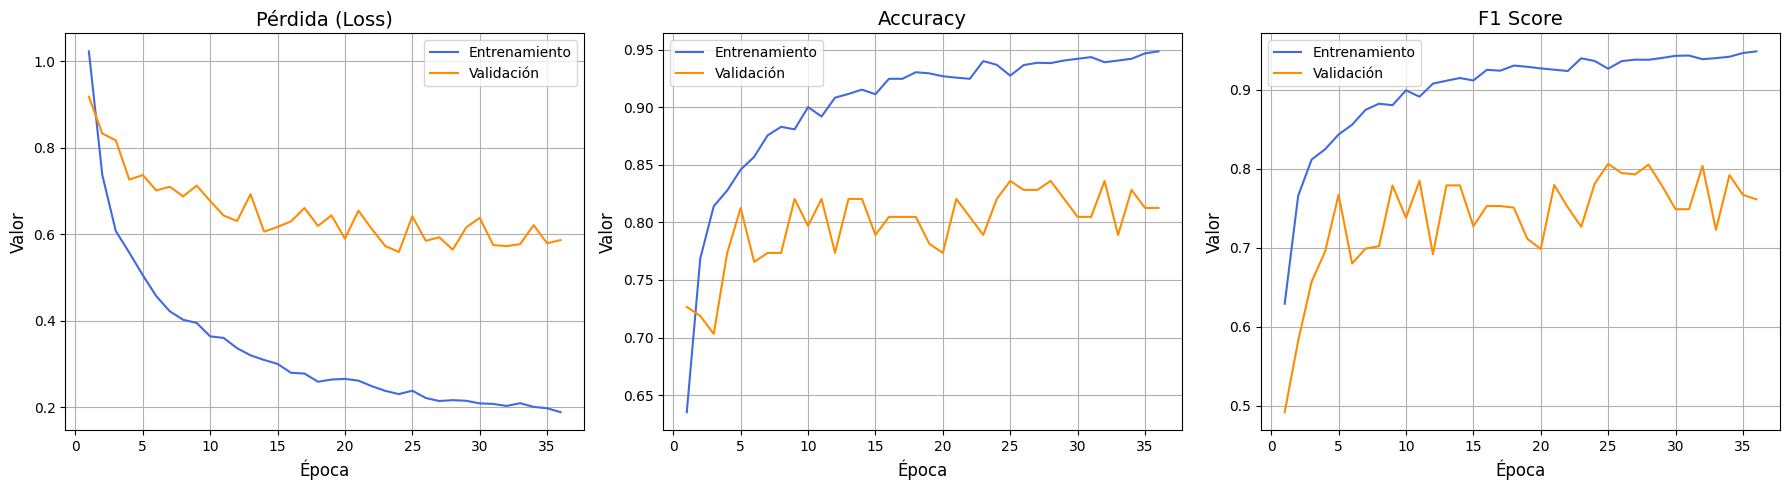

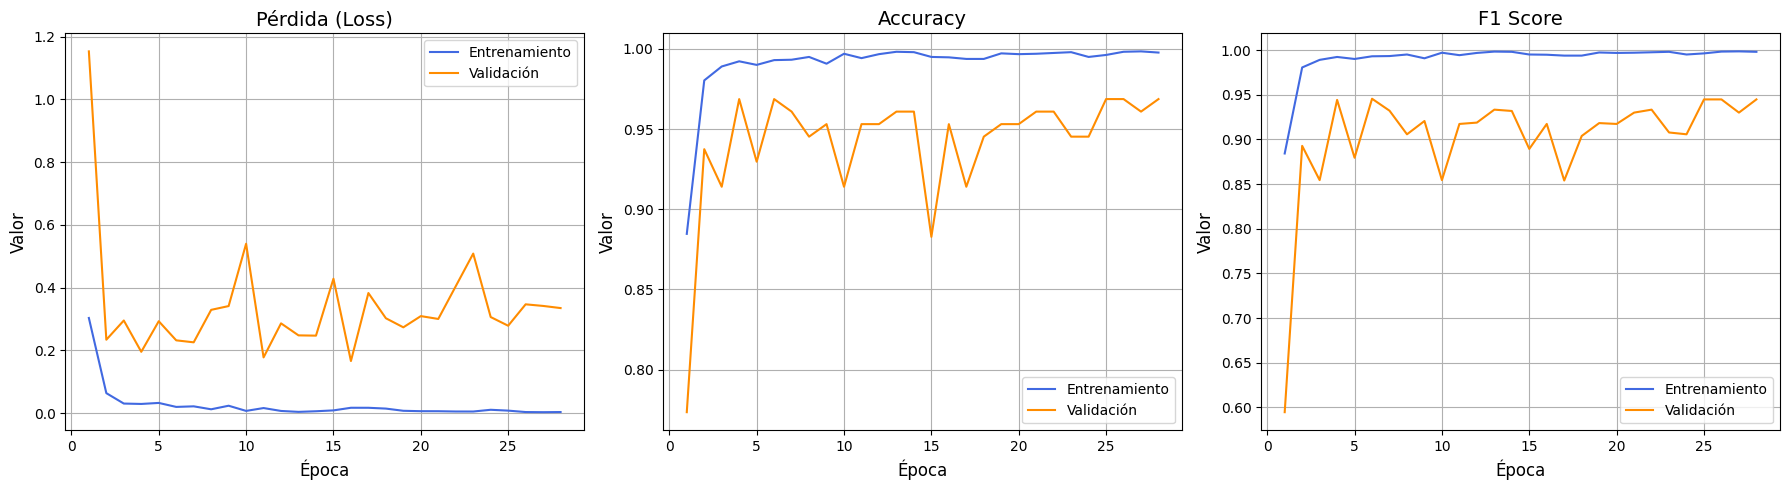

In [12]:
plot_train_results_from_json(json_file='data/resnet50_fc_train_results.json')
plot_train_results_from_json(json_file='data/resnet50_layer4_fc_train_results.json')

Evaluando ResNet50 con Transfer Learning. Resultados: 
Resultados guardados en data/resnet50_fc_evaluation_results.json


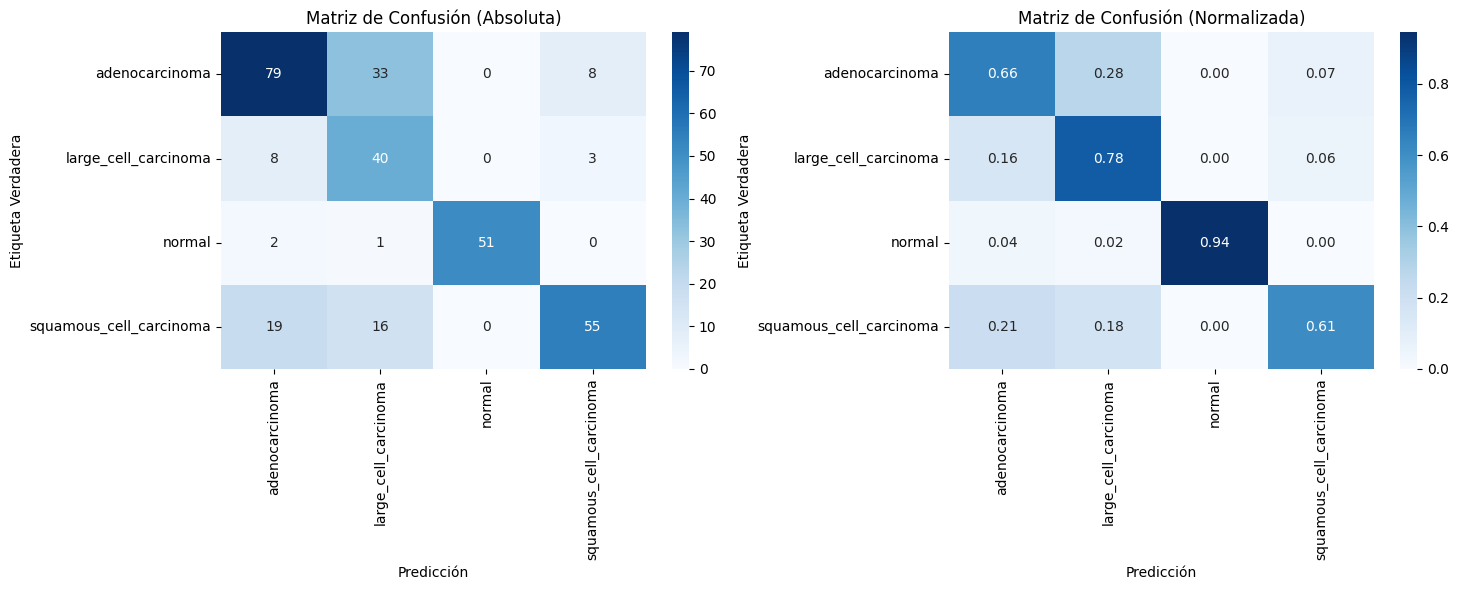

Evaluando ResNet50 con Fine Tuning. Resultados: 
Resultados guardados en data/resnet50_layer4_fc_evaluation_results.json


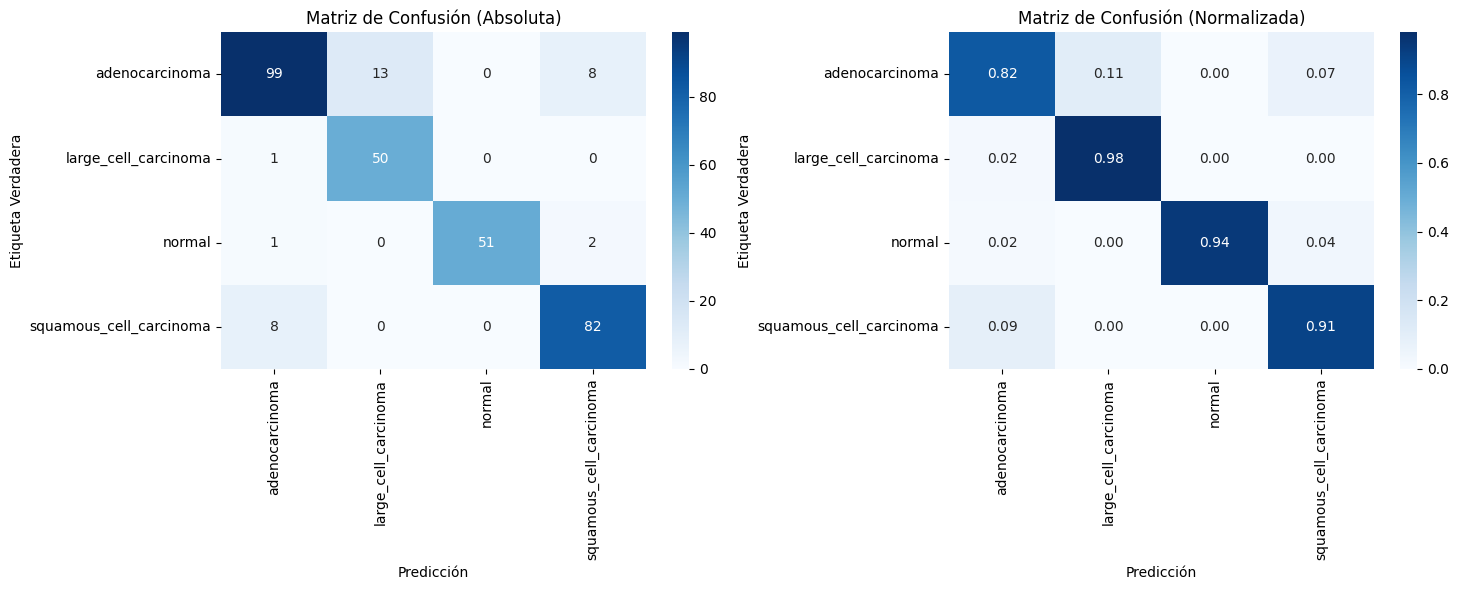

In [13]:
print("Evaluando ResNet50 con Transfer Learning. Resultados: ")
evaluate_model(resnet50_tl_model, test_loader, test_dataset.classes, device, output_file='data/resnet50_fc_evaluation_results.json')
print("Evaluando ResNet50 con Fine Tuning. Resultados: ")
evaluate_model(resnet50_ft_model, test_loader, test_dataset.classes, device, output_file='data/resnet50_layer4_fc_evaluation_results.json')